In [1]:
import pandas                    as     pd
from   sklearn.neighbors         import NearestNeighbors
from   sklearn.neighbors         import KNeighborsClassifier
from   sklearn.model_selection   import GridSearchCV
from   sklearn.preprocessing     import LabelEncoder
from   sklearn.feature_selection import SelectKBest, f_classif
from   IPython.display           import display
import matplotlib.pylab          as     plt 
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importamos el dataset 
def get_data(file):
    df= pd.read_csv(file)
    print(df.shape)
    display(df.head(2))
    return df

In [20]:
#crea una variable que indica si una persona es adulta o no
def get_adultos(df):
    df["adulto"]=0
    df["adulto"][df["age"] >= 18] = 1
    return df

In [21]:
#funcion para eliminar features
def drop_feature(df,feature):
    X=df
    for i in feature:
        X=X.drop(i,1)
    return X    

In [24]:
filedtrain = 'titanic_train.csv'
filedtest  = 'titanic_eval.csv' 
df_train   =  get_data(filedtrain) 
df_test    =  get_data(filedtest)
X_0 = pd.concat([df_train, df_test], axis=0)

(627, 10)


,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n


(264, 10)


,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y


In [27]:
X_0["deck"].unique()

array(['unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'], dtype=object)

##### Predecir la si una persona sobrevive o no
1. survival. Es la variable objetivo toma valores 0 = No, 1 = SI
2. sexo. Sexo de la persona
3. age. Edad en años
4. n_siblings_spouses. # de hermanos / cónyuges a bordo del Titanic
5. parch. # de padres / hijos a bordo del Titanic
6. fare. Tarifa de pasajero
7. class. Es la clase en el ticket, 	First, Second, Third
8. deck. indica la sección donde estaba el pasajero 'unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'.
9. embark_town. Puerto de embarque
10. alone. si viajaba solo o no.

In [28]:
#imprimimos los tipos de datos
print(X_0.dtypes)

survived                int64
sex                    object
age                   float64
n_siblings_spouses      int64
parch                   int64
fare                  float64
class                  object
deck                   object
embark_town            object
alone                  object
dtype: object


In [29]:
#verificamos que no haya valores faltantes
print(X_0.isnull().sum())

survived              0
sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64


#### Vemos las relaciones entre los sobrevivientes y las covariables

sex,female,male
survived,,
0,81,468
1,233,109


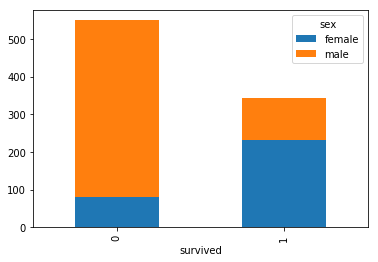

In [30]:
#sobrevivientes vs sexo
survssex=pd.crosstab(X_0.survived,X_0.sex)
display(survssex)
survssex.plot.bar(stacked=True)

survived,0,1
class,,
First,80,136
Second,97,87
Third,372,119


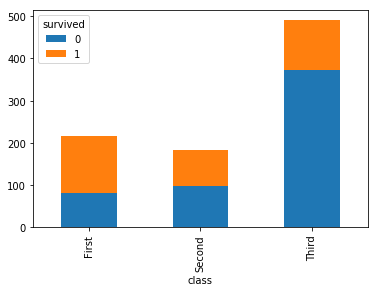

In [31]:
#sobrevivientes vs clase
survsclass = pd.crosstab(X_0["class"],X_0.survived)
display(survsclass)
survsclass.plot.bar(stacked=True)

In [32]:
X_0=get_adultos(X_0)

adulto,0,1
survived,,
0,52,497
1,61,281


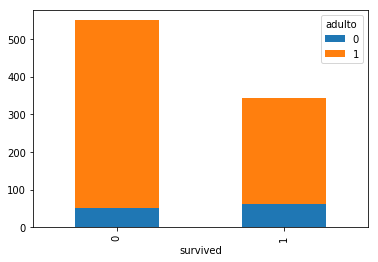

In [33]:
survsadulto=pd.crosstab(X_0.survived,X_0.adulto)
display(survsadulto)
survsadulto.plot.bar(stacked=True)

In [34]:
#separamos las covariables y la variable de respuesta.
y_train=df_train.pop("survived")
X_train=df_train
y_test=df_test.pop("survived")
X_test=df_test

In [35]:
#aplicamos un string indexer
col=["sex","class","deck","embark_town","alone"]
def stringIndexer(df,col):
    X=df
    for i in col:
        X[i+"strindexer"]=LabelEncoder().fit_transform(X[i]) 
        X=X.drop(i,1)
    return X

In [36]:
X_train=stringIndexer(X_train,col)
X_test=stringIndexer(X_test,col)
X_test.head(2)

,age,n_siblings_spouses,parch,fare,sexstrindexer,classstrindexer,deckstrindexer,embark_townstrindexer,alonestrindexer
0,35.0,0,0,8.0500,1,2,6,2,1
1,54.0,0,0,51.8625,1,0,4,2,1


### Hiperparametros
1. weights{'uniform', 'distance'} or callable, default='uniform':
   función de peso utilizada en la predicción. Valores posibles:
     
   1.1 'uniform': pesos uniformes. Todos los puntos de cada vecindad se ponderan por igual.
   
   1.2 'distance': los puntos son pesados la inversa de su distancia. En este caso, los vecinos más cercanos de un punto de consulta tendrán una mayor influencia que los vecinos que están más lejos.

    1.3 'callable': una función definida por el usuario que acepta una matriz de distancias y devuelve una matriz de la misma forma que contiene los pesos.
2. k: el número de vecinos    

In [37]:
#Probaremos con diferentes valores de k de tal manera que se mejore la exactitud del modelo
k_range = list(range(1,12))
score   = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train,y_train)
    score.append(knn.score(X_test, y_test))

Text(0.5,1,'Valores de k vs exactitud')

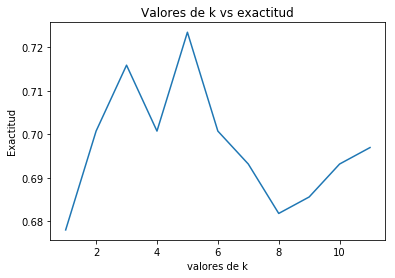

In [38]:
plt.plot(k_range,score)
plt.xlabel("valores de k")
plt.ylabel("Exactitud")
plt.title("Valores de k vs exactitud")

In [39]:
#con GridSearchCV mediante validación cruzada escogemos los valores de los hiperparametros que
#mejoran el accuracy
knn = KNeighborsClassifier( )
pesos = ['uniform','distance']
hiperparam = dict(n_neighbors=k_range, weights = pesos)
model = GridSearchCV(knn, hiperparam, cv=10, scoring = 'accuracy')
model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [40]:
#obtenmos el score del modelo
print("model score: %.3f" % model.score(X_test, y_test))

model score: 0.731


In [41]:
print ("Mejores hiperparametros: ",str(model.best_params_))

Mejores hiperparametros:  {'n_neighbors': 6, 'weights': 'distance'}


In [42]:
#si unicamente queremos imprimir el valor k que mejora el modelo
print(model.best_estimator_.kneighbors)

<bound method KNeighborsMixin.kneighbors of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='distance')>


#### Mejorameinto del modelo
¿Qué mejoras podemos realizar? hacer una selección de variables con SelectKBest elimina todas las características de puntuación más alta excepto k. Los métodos basados en la prueba F estiman el grado de dependencia lineal entre dos variables aleatorias

In [43]:
X_0.shape
y=LabelEncoder().fit_transform(X_0["survived"])
X_0=X_0.drop(["survived"],axis=1)
X_0.head(1)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone,adulto
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n,1


In [44]:
X_0=stringIndexer(X_0,col)
X_0.head(2)

,age,n_siblings_spouses,parch,fare,adulto,sexstrindexer,classstrindexer,deckstrindexer,embark_townstrindexer,alonestrindexer
0,22.0,1,0,7.2500,1,1,2,7,2,0
1,38.0,1,0,71.2833,1,0,0,2,0,0


In [45]:
fselect = SelectKBest(f_classif, k='all')
scores_fit = fselect.fit(X_0, y)
features_score = scores_fit.scores_.round(3)

In [46]:
#imprimimos el valor de los scores 
features_score

array([  3.762,   1.111,   5.963,  63.031,  13.485, 372.406, 115.031,
        84.617,  24.423,  38.354])

In [47]:
#los visualizamos en una tabla 
features= list(X_0.columns.values)
selected_features = fselect.get_support([scores_fit])
feat_list = [ ]
for i in selected_features:
    feat_list.append({'Feature':features[i], 'Score': features_score[i]  })
features_select = pd.DataFrame(feat_list)
features_select

,Feature,Score
0,age,3.762
1,n_siblings_spouses,1.111
2,parch,5.963
3,fare,63.031
4,adulto,13.485
5,sexstrindexer,372.406
6,classstrindexer,115.031
7,deckstrindexer,84.617
8,embark_townstrindexer,24.423
9,alonestrindexer,38.354


De la tabla anterior podemos visualiza que podriamos elminar algunas covariables como los son age, n_siblings_spouses... y las covariables que más no aportan son sexstrindexer, classstrindexer.


In [48]:
#agregamos si son adultos o no, a los dataframes de entrenamiento y test
X_train = get_adultos(X_train)
X_test  = get_adultos(X_test)

In [49]:
#eliminamos las variables antes mencionadas
droplist=["n_siblings_spouses","parch","embark_townstrindexer","alonestrindexer","age"]
X_train=drop_feature(X_train,droplist)
X_test=drop_feature(X_test,droplist)

In [50]:
#dataframe final 
X_train.head(2)

,fare,sexstrindexer,classstrindexer,deckstrindexer,adulto
0,7.2500,1,2,7,1
1,71.2833,0,0,2,1


In [52]:
k_range = list(range(1,12))
pesos = ['uniform','distance']
hiperparam = dict(n_neighbors=k_range, weights = pesos)
model = GridSearchCV(knn, hiperparam, cv=10, scoring = 'accuracy')
model.fit(X_train, y_train)
print("model score: %.3f" % model.score(X_test, y_test))

model score: 0.799


### Conclusión 
Es muy importante hacer un análisis respecto a las variables a considerar ya que vemos que al momento de seleccionar mejora considerablemente la prediccón.